# Text Classification

Course: Business Intelligence  
Universidad de los Andes  
September, 2023

In [8]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import numpy as np
import pandas as pd
import nltk


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Configuring pandas to show all cell content
pd.set_option("display.max_colwidth", None)

In [12]:
# Downloading stopwords
nltk.download("punkt")
nltk.download("stopwords")
stop_words = stopwords.words("english")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Data loading and preparation

In [14]:
fakes_df = pd.read_csv("./data/fake-news-unbalanced.csv")

In [15]:
fakes_df.shape

(12990, 5)

In [16]:
fakes_df.sample(5)

id  \
360   15010   
3852   2541   
4047   2929   
6509   7797   
5701   6192   

                                                                                                                               title  \
360                                                                 Donald J. Trump’s 10 Point Plan to Put America First: A Response   
3852                                                                             Sleep Is the New Status Symbol - The New York Times   
4047                                 Capitol Hill Source: Intel Chair Nunes Temporarily Vacated Russia Probe to Keep Focus on Russia   
6509  Trump: ’Sometimes You Have to Fuel the Well’ - Military ’More Important’ Than a Balanced Budget, ’We’ll Get There’ - Breitbart   
5701                       Russian Official Apologizes for Doping Problem but Says Athletes Shouldn’t Be Barred - The New York Times   

              author  \
360        Anonymous   
3852  Penelope Green   
4047  Neil W. McCabe   
6509    Ian Hanchett   
5701    Mike McPhate   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [17]:
fakes_df["label"].value_counts(dropna=False, normalize=True)

label
0    0.799615
1    0.200385
Name: proportion, dtype: float64

In [18]:
fakes_df["title"] = fakes_df["title"].astype(str)
fakes_df["text"] = fakes_df["text"].astype(str)

## Data splitting

In [19]:
# The param 'stratify' is useful to guarantee label proportions on train and test sets
X_train, X_test, y_train, y_test = train_test_split(fakes_df[["title", "text"]], fakes_df["label"], test_size=0.3, stratify=fakes_df["label"], random_state=1)

<span style="color: red;">Why is useful to set a `random_state` value?</span>

In [20]:
X_train.shape, X_test.shape

((9093, 2), (3897, 2))

In [21]:
pd.Series(y_train).value_counts(normalize=True)

label
0    0.799626
1    0.200374
Name: proportion, dtype: float64

In [22]:
pd.Series(y_test).value_counts(normalize=True)

label
0    0.799589
1    0.200411
Name: proportion, dtype: float64

## Text vectorization

Let's explore the most common techniques for doing text vectorization. Despite these are classical approaches, yet continue having competitive performance for relatively simple tasks like classification.  

The main disadvantage of these techniques are the high-dimensionality of the resulting vectors and the loss of context among tokens represented by each feature.

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="https://miro.medium.com/v2/resize:fit:880/1*hLvya7MXjsSc3NS2SoLMEg.png" style="height: 280px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="https://miro.medium.com/v2/resize:fit:1400/1*qQgnyPLDIkUmeZKN2_ZWbQ.png" style="height: 350px;">
            </td>
        </tr>
    </tbody>
</table>

<span style="color: red;">Will both techniques generate vectors of the same dimensionality?</span>

In [23]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [24]:
X_bow = bow.fit_transform(X_train["title"])

In [25]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 15149


In [26]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [27]:
X_tfidf = tfidf.fit_transform(X_train["title"])

In [28]:
print("Vocabulary size:", len(tfidf.vocabulary_))

Vocabulary size: 15149


## Training a model with BoW

In [29]:
bow_model = RandomForestClassifier(random_state=2)

In [30]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

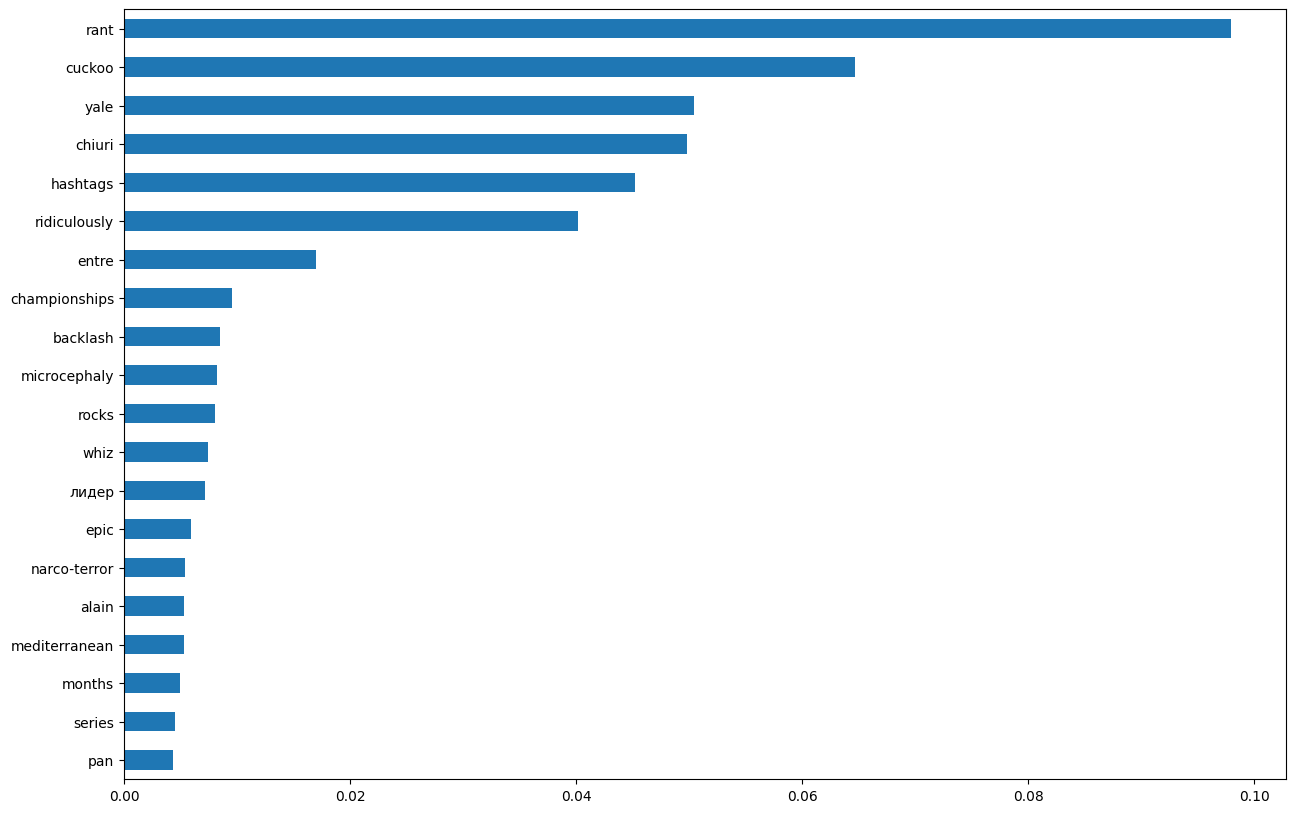

In [31]:
# Feature importance in tree models is an indicator on how relevant is a feature for taking the decision by the model
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [32]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 311.61


In [33]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["title"]))

<img src="https://miro.medium.com/v2/resize:fit:1334/format:webp/1*3yGLac6F4mTENnj5dBNvNQ.jpeg" height="500" />

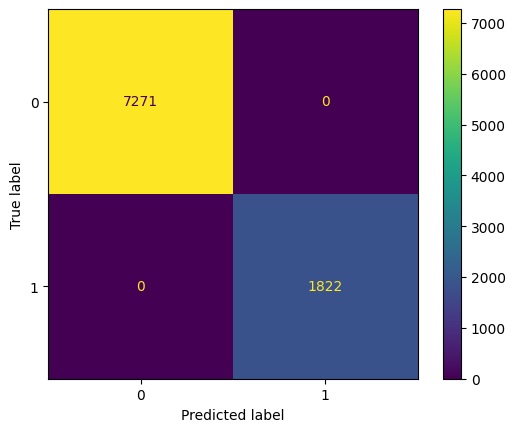

In [34]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

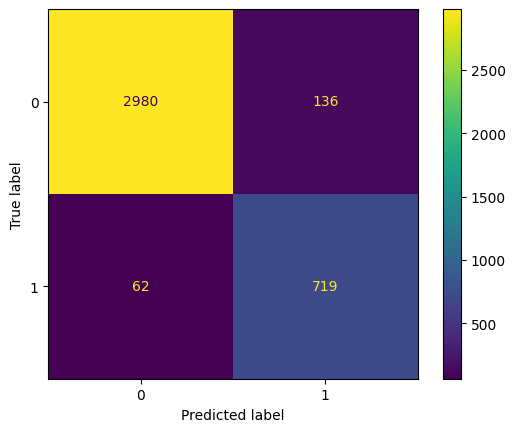

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

<img src="https://static.packt-cdn.com/products/9781785282287/graphics/B04223_10_02.jpg" height="250" />

In [36]:
print("Precision:", precision_score(y_train, y_train_bow_predict))
print("Recall:", recall_score(y_train, y_train_bow_predict))
print("F1:", f1_score(y_train, y_train_bow_predict))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [37]:
print("Precision:", precision_score(y_test, y_test_bow_predict))
print("Recall:", recall_score(y_test, y_test_bow_predict))
print("F1:", f1_score(y_test, y_test_bow_predict))

Precision: 0.8409356725146199
Recall: 0.9206145966709347
F1: 0.8789731051344744


## Training a model with TF-IDF

In [38]:
tfidf_model = RandomForestClassifier(random_state=3)

In [39]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

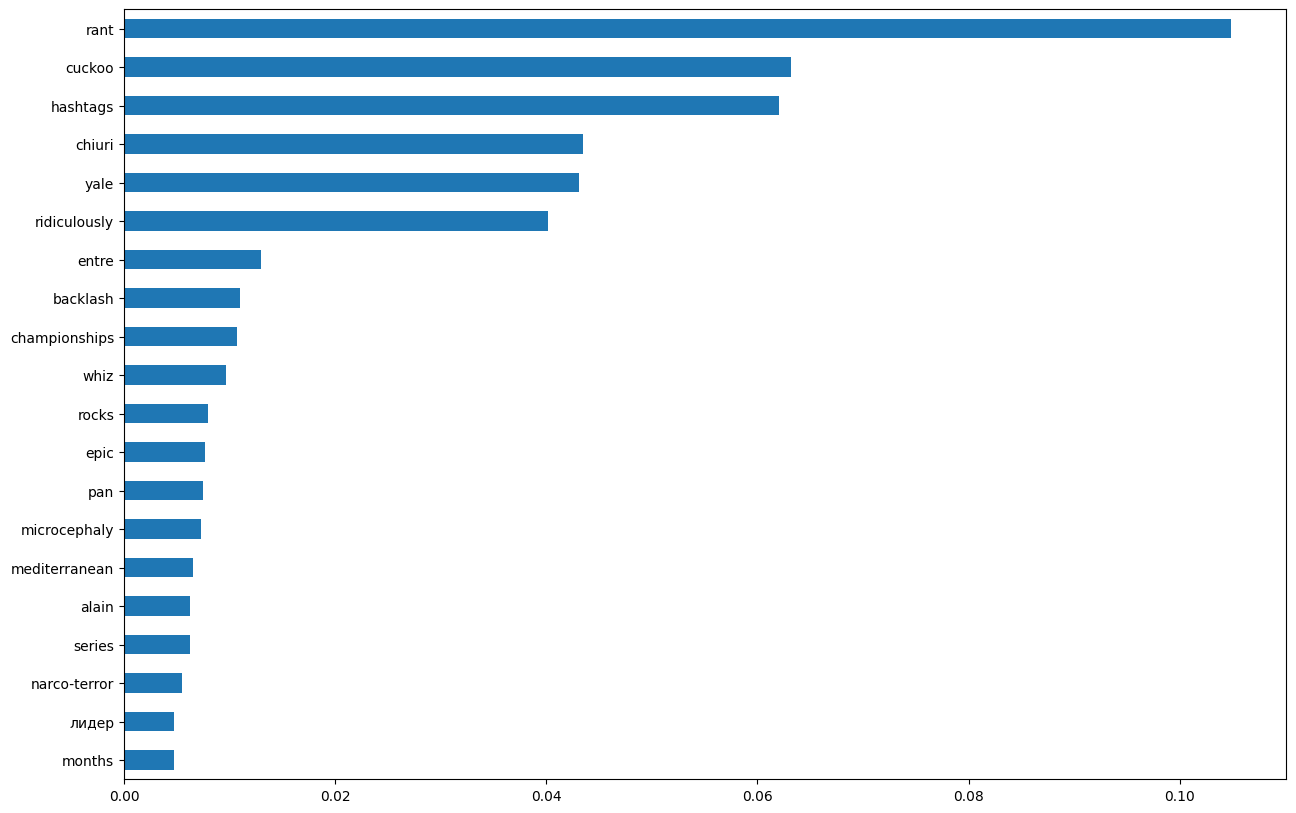

In [40]:
pd.Series(tfidf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [41]:
tfidf_estimators = tfidf_model.estimators_
print("Number of trees:", len(tfidf_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 316.69


In [42]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test["title"]))

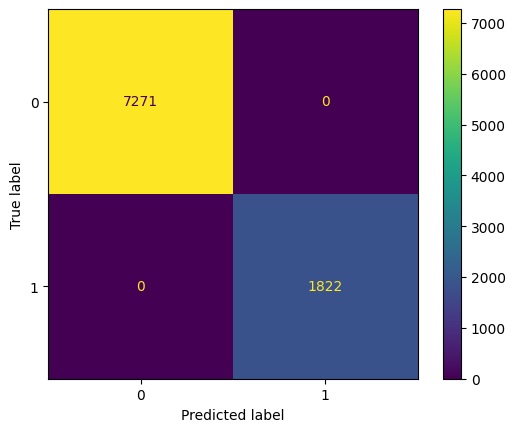

In [43]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

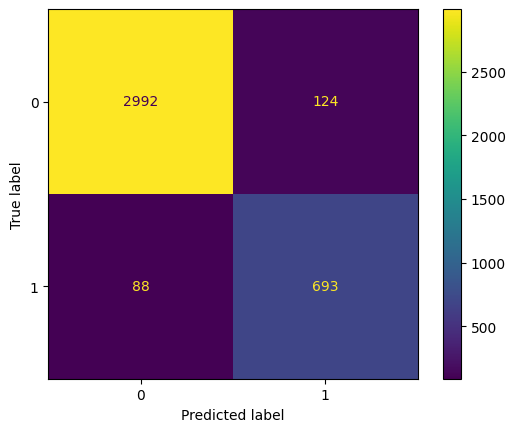

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [45]:
print("Precision:", precision_score(y_train, y_train_tfidf_predict))
print("Recall:", recall_score(y_train, y_train_tfidf_predict))
print("F1:", f1_score(y_train, y_train_tfidf_predict))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [46]:
print("Precision:", precision_score(y_test, y_test_tfidf_predict))
print("Recall:", recall_score(y_test, y_test_tfidf_predict))
print("F1:", f1_score(y_test, y_test_tfidf_predict))

Precision: 0.8482252141982864
Recall: 0.8873239436619719
F1: 0.867334167709637


### Model selection

In [47]:
pipeline = Pipeline(steps = [
    ("vectorizer", CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)),
    ("classifier", RandomForestClassifier(random_state=4))
])

In [48]:
param_grid = {
    "vectorizer": [CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words), TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words)],
    "vectorizer__lowercase": [True, False],
    "classifier__n_estimators": [50, 100],
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__max_depth": [25, 50, 75, 100]
}

In [49]:
search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, scoring=["precision", "recall", "f1"], refit="f1", cv=10, return_train_score=True, verbose=1, random_state=5)

In [50]:
search.fit(X_train["title"], y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('vectorizer',
                                              CountVectorizer(stop_words=['i',
                                                                          'me',
                                                                          'my',
                                                                          'myself',
                                                                          'we',
                                                                          'our',
                                                                          'ours',
                                                                          'ourselves',
                                                                          'you',
                                                                          "you're",
                                                                          "you've",
                                                                          "you'll",
                                                                          "you'd",
                                                                          'your',
                                                                          'yours',
                                                                          'yourself',
                                                                          'yourselves',
                                                                          'he',
                                                                          'him',
                                                                          'his',
                                                                          'himself',
                                                                          'she',
                                                                          "she's",
                                                                          'her',
                                                                          'hers',
                                                                          'herself',
                                                                          'it',
                                                                          "it's",
                                                                          'its',
                                                                          'itself', ...],
                                                              tokenizer=<function word_toke...
                                                                                   "you've",
                                                                                   "you'll",
                                                                                   "you'd",
                                                                                   'your',
                                                                                   'yours',
                                                                                   'yourself',
                                                                                   'yourselves',
                                                                                   'he',
                                                                                   'him',
                                                                                   'his',
                                                                                   'himself',
                                                                                   'she',
                                                                                   "she's",
                                                                                   'her',
                                                   

In [51]:
search.best_params_

{'vectorizer__lowercase': False,
 'vectorizer': CountVectorizer(lowercase=False,
                 stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                             'ourselves', 'you', "you're", "you've", "you'll",
                             "you'd", 'your', 'yours', 'yourself', 'yourselves',
                             'he', 'him', 'his', 'himself', 'she', "she's",
                             'her', 'hers', 'herself', 'it', "it's", 'its',
                             'itself', ...],
                 tokenizer=<function word_tokenize at 0x000001B22FFD2660>),
 'classifier__n_estimators': 100,
 'classifier__max_depth': 100,
 'classifier__criterion': 'entropy'}

In [52]:
search.best_score_

0.8809494888296348

In [53]:
y_train_search_predict = search.best_estimator_.predict(X_train["title"])
y_test_search_predict = search.best_estimator_.predict(X_test["title"])

In [54]:
print("Precision:", precision_score(y_train, y_train_search_predict))
print("Recall:", recall_score(y_train, y_train_search_predict))
print("F1:", f1_score(y_train, y_train_search_predict))

Precision: 0.9789075175770687
Recall: 0.9934138309549945
F1: 0.986107327703623


In [55]:
print("Precision:", precision_score(y_test, y_test_search_predict))
print("Recall:", recall_score(y_test, y_test_search_predict))
print("F1:", f1_score(y_test, y_test_search_predict))

Precision: 0.900523560209424
Recall: 0.8809218950064021
F1: 0.8906148867313916
